# LAND PRICE PREDICTION APP USING AWS SAGEMAKER'S IN-BUILT XGBOOST  - End-to-End
We will build a Land Price Prediction App to help people looking to buy land in Cameroon, get the expected price of land per quartier they intend to buy land from.
The following steps will be taken:
- I)   PROBLEM STATEMENT:

Many people in Cameroon want to buy lands and they have trouble getting information on what to expect as price per square metre for the quartier they want to buy the land from.They also want to be able to consult the prices of several quartiers before making their final choice.
This is a difficult process in Cameroon as it will mean these people who want to buy lands will have to go about making many phone calls to people asking them the price of land in those quartiers.
So the objective is to scrape the data already available on the biggest Classified adds website in Cameroon (Jumia Cameroon) https://www.jumia.cm/en/land-plots

This data will be cleaned and trained using the in-built XGBoost Algorithm on AWS Sagemaker, and an endpoint will be created in AWS ,which wll be used to make predictions when given the inputs like 
- The Quartier the customer wants to buy land from
- The size of the land the customer intends to buy (in metres square)
- And the output of the model will be the predicted Price per metres square for the Quartier the customer requested.


- II)   SCRAPING THE DATA:

Scrape the data from a Classified ads website, where people post lands for sale per quartier in Cameroon.They typically type in the price per metres square and the total area of the land availlable for sale.
- III)  PERFORM EXPLORATORY DATA ANALYSIS 

Inspect the data to validate the quality of the data scraped from the classified ads website. Analyse the distribution of missing values, outliers and gain other relevant insights from the model
- IV) DO FEATURE ENGINEERING & SELECTION

Handle the mising values, outliers and do the necessary transformations which will ensure the data is well suited for the machine learning model.And also to maximise the insights gotten from the Exploratory Data Analysis phase.
- V)  BUILD,TRAIN AND DEPLOY THE MODEL IN SAGEMAKER

The Boto3 Container will be used to create the S3 buckets to store the preprocessed dataset.The Sagemaker's inbuilt XGBoost algorithm, will be built, trained and deployed.Including the use of optimal hyperparameters to get the best results for the RMSE( Root Mean Squared Error).An Endpoint will be created after the model is built.
The Endpoint created awill be used to predict the price per metre square when the inputs of "Quartier" and "Land size" are fed to the endpoint.

### IV) FEATURE ENGINEERING & SELECTION
We will perform the following tasks in order to successfully complete the Feature Engineering
- a.) Importing the necessary Libraries and scraped data
- b.) Fixing the "Price" data entry inconsistencies
- c.) Train test split
- d.) Missing Values Treatment
- e.) Outliers Treatment
- f.) Categorical Variable Treatment
- g.) Preparing and exporting train data as a CSV
- h.) Preparing and exporting test data as a CSV

#### a.) Importing the necessary Libraries

In [74]:
#Importing libraries we will need in this phase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [75]:
#View the first 5 observations
dataset = pd.read_csv("land_price_data.csv",index_col = 0)

print(dataset.head())

   Price Location     Area
0   8000   Douala  10000.0
1  55000    Yassa    300.0
2  55000    Yassa    200.0
3  55000   Japoma    735.0
4  55000   Japoma   1500.0


In [76]:
#View the shape of the data
dataset.shape

(4490, 3)

#### b.) Fixing the "Price" data entry inconsistencies

From the previous phase of the Exploratory Data Analysis, we noticed that data coming form the classified ads were having some inconsistencies in the "Price" variabl.While some prices were enetered as "Price per metres square" others were entered as the total sales amout of "price per m2 * area" some inconsistencies.So we will start by trying to fix that before splitting the data to train and test set.

In [77]:
#Viewing the descriptive statistics for the "Price" column
print(dataset.Price.describe())

count    4.490000e+03
mean     4.961029e+07
std      8.482607e+08
min      0.000000e+00
25%      1.000000e+04
50%      3.500000e+04
75%      5.000000e+05
max      4.500000e+10
Name: Price, dtype: float64


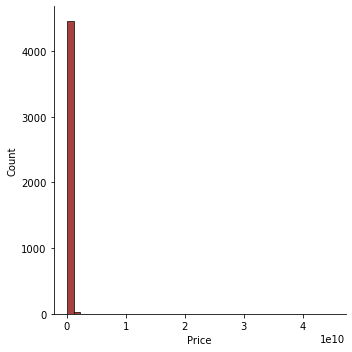

In [78]:
#Plot to see the distribution of Price
sns.displot(dataset['Price'].dropna(),kde=False,color='darkred',bins=40)

In [79]:
#Create new column for Prices above the 75th percentile and divide by Area to correct the inconsistencies seen in the EDA
dataset['Price2'] = np.where(dataset['Price'] > 500000 ,round(dataset['Price']/ dataset['Area']) , dataset['Price'])
print(dataset)

      Price  Location     Area   Price2
0      8000    Douala  10000.0   8000.0
1     55000     Yassa    300.0  55000.0
2     55000     Yassa    200.0  55000.0
3     55000    Japoma    735.0  55000.0
4     55000    Japoma   1500.0  55000.0
...     ...       ...      ...      ...
4485   6500     Yassa    150.0   6500.0
4486  17000    Tsinga   1000.0  17000.0
4487  50000  Bonaberi    300.0  50000.0
4488  50000  Bonaberi   1000.0  50000.0
4489  65000  Bonaberi    500.0  65000.0

[4490 rows x 4 columns]


In [80]:
#Cuttoff thresholds to reduce outliers from the extemeties
min_threshold,max_threshold = dataset["Price2"].quantile([0.005,0.985])
min_threshold,max_threshold

(137.25, 500000.0)

In [81]:
#Take a look at the obsevations below the min cuttoff
dataset[dataset.Price2<min_threshold]

,Price,Location,Area,Price2
104,650000,Soa,400000.0,2.0
212,10000000,PK12,120000.0,83.0
358,1500000,Foumbot,50000.0,30.0
970,900000,Limbé,10000.0,90.0
1305,7000000,Kribi,200000.0,35.0
1884,3000000,Yabassi,500000.0,6.0
2061,3500000,PK33,32000.0,109.0
2076,3000000,Yabassi,50000.0,60.0
2171,3000000,Yabassi,30000.0,100.0
2172,3000000,Yabassi,30000.0,100.0


In [82]:
#Take a look at the observations above the max cuttoff
dataset[dataset.Price2>max_threshold]

,Price,Location,Area,Price2
21,200000000,Bonamoussadi,300.0,666667.0
138,300000000,Akwa,449.0,668151.0
150,200000000,Bonamoussadi,300.0,666667.0
386,600000000,Bali,500.0,1200000.0
540,950000000,Bonapriso,886.0,1072235.0
589,160000000,Akwa,304.0,526316.0
628,340000000,Bonapriso,363.0,936639.0
1266,700000000,Bonapriso,832.0,841346.0
1401,1500000000,Yaoundé,1500.0,1000000.0
1464,918000000,Bonanjo,918.0,1000000.0


In [83]:
#Create a new dataset within the cuttoffs
dataset = dataset[(dataset.Price2>min_threshold) & (dataset.Price2<max_threshold)]
dataset.shape

(4341, 4)

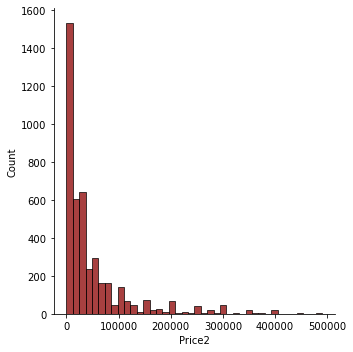

In [84]:
#Plot to see the distribution of Price
sns.displot(dataset['Price2'].dropna(),kde=False,color='darkred',bins=40)

In [85]:
#Check the distribution of Area
dataset.Area.describe()

count      4163.000000
mean       9272.863080
std       38557.397401
min           0.000000
25%         500.000000
50%        1000.000000
75%        5350.000000
max      500000.000000
Name: Area, dtype: float64

In [86]:
#Removing lands above 5000 metres Square. Since these are mostly farmlands and our model os for residential lands
dataset = dataset[dataset['Area'] <= 5000 ]
dataset.describe()

,Price,Area,Price2
count,3.119000e+03,3119.000000,3119.000000
mean,1.296098e+07,1069.658224,62362.440846
std,5.111647e+07,1100.444056,75223.211832
min,6.420000e+02,0.000000,181.000000
25%,2.500000e+04,450.000000,15000.000000
50%,6.000000e+04,600.000000,35000.000000
75%,5.000000e+06,1006.000000,75000.000000
max,1.500000e+09,5000.000000,490884.000000


So now we have corrected the inconsistencies, especially for the high values.Now the dataset has greatly improved.It still has outliers, but that is also because house prices in some neighbourhoods at the heart of the city are very expensive.

Next, let us move on to split the data between train and test datasets to avoid data leakage.

#### c.) Train test split

In [87]:
# Preparing the Dependent Variables
X = dataset.loc[:,['Location','Area']]
X.head()

,Location,Area
1,Yassa,300.0
2,Yassa,200.0
3,Japoma,735.0
4,Japoma,1500.0
6,Biyem-Assi,270.0


In [88]:
# Preparing the Independent Variable
y = dataset.loc[:,['Price2']]
y.head()

,Price2
1,55000.0
2,55000.0
3,55000.0
4,55000.0
6,59259.0


In [89]:
# Use scikit learn to split the dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [90]:
# Creating one training dataset
train_set = pd.concat([X_train,y_train],axis = 1)
train_set

,Location,Area,Price2
1238,Kribi,3000.0,35000.0
4063,Makepe,200.0,110000.0
2508,Yassa,450.0,40000.0
3411,Odza,798.0,40000.0
981,Yassa,1900.0,18000.0
...,...,...,...
1095,Essomba,500.0,80000.0
1198,PK21,500.0,5000.0
2354,Logbessou,1173.0,65000.0
3729,Odza,1250.0,25000.0


We now have the training set.Let us move on to treating the missing values in the "Area" variable.

#### d.) Treating Missing Values

In [91]:
#View the count of the Area Variable compared to the count of Price2 
train_set.describe()

,Area,Price2
count,2495.000000,2495.000000
mean,1080.234469,61174.927054
std,1115.628541,74229.477587
min,0.000000,251.000000
25%,450.000000,15000.000000
50%,600.000000,35000.000000
75%,1033.500000,75000.000000
max,5000.000000,490884.000000


In [92]:
#Import scikit learn imputer to impute the median
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan,strategy='median')

In [93]:
#Fit and transform the Area Varible with the meedian value
train_set['Area'] = imp.fit_transform(train_set[['Area']])
train_set.describe()

,Area,Price2
count,2495.000000,2495.000000
mean,1080.234469,61174.927054
std,1115.628541,74229.477587
min,0.000000,251.000000
25%,450.000000,15000.000000
50%,600.000000,35000.000000
75%,1033.500000,75000.000000
max,5000.000000,490884.000000


Missing values for Area have been replaced by the median Area (which is 1000 metres square).

Next let us take care of the outliers in the dependent variable.This will help reduce the bias from the machine learning model.

#### e.) Outliers Treatment

In [94]:
#Apply logs to the Price column 
train_set['Price_log'] = train_set.Price2.transform(np.log)
train_set.head()

,Location,Area,Price2,Price_log
1238,Kribi,3000.0,35000.0,10.463103
4063,Makepe,200.0,110000.0,11.608236
2508,Yassa,450.0,40000.0,10.596635
3411,Odza,798.0,40000.0,10.596635
981,Yassa,1900.0,18000.0,9.798127


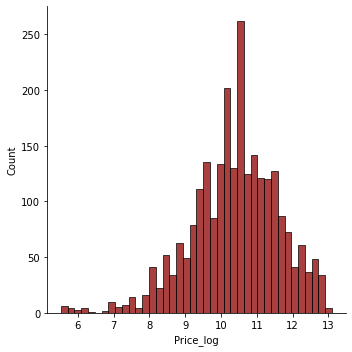

In [95]:
#Plot to see the if Price is a lognormal distribution
sns.displot(train_set['Price_log'].dropna(),kde=False,color='darkred',bins=40)

After taking logs for the "Price" variable the distribution now looks close to Normal.

Next let us treat the categorical variables and try to isolate just the popular locations as seen in the EDA.

#### f.) Categorical Variable Treatment

<AxesSubplot:xlabel='Location', ylabel='count'>

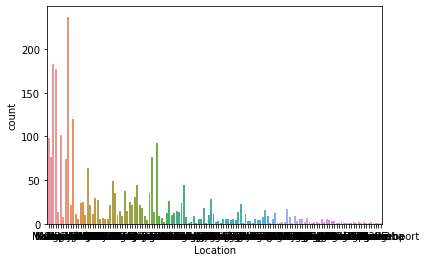

In [96]:
#Looking at the distribution of Location
sns.countplot(x='Location',data = train_set)

In [97]:
#Looking at the number of categories
print(f"The number of categories in the Location variable is : {train_set['Location'].nunique()} locations  \n ")
print(train_set['Location'].unique())

The number of categories in the Location variable is : 136 locations  
 
['Kribi' 'Makepe' 'Yassa' 'Odza' 'Nkolfoulou' 'Logpom' 'Nsimeyong' 'Lendi'
 'Yaoundé' 'Bonapriso' 'Logbessou' 'Ndokoti' 'Cité Sic' 'Nyalla' 'PK14'
 'Beedi' 'Kotto' 'Nkolbisson' 'Nyom' 'PK12' 'PK16' 'Nsam' 'PK27'
 'Mballa 2' 'PK13' 'PK21' 'Nkoabang' 'Bastos' 'Damase' 'Biyem-Assi' 'PK33'
 'Mfou' 'Ndog-Bong' 'Omnisports' 'Mendong' 'Awae' 'Bonamoussadi' 'PK19'
 'Mimboman' 'Nkomo' 'Ekoumdoum' 'Soa' 'Japoma' 'Ngousso' 'Limbé'
 'Akwa Nord' 'Akwa' 'Obala' 'Messassi' 'Olembe' 'Biteng' 'Deido' 'Denver'
 'Efoulan' 'Ahala' 'Bonaberi' 'Tsinga' 'Dakar' 'BEAC' 'Bonanjo' 'Ebolowa'
 'Ndogpassi2' 'Ndogpassi' 'Messamendongo' 'Mokolo' 'Logbaba' 'Village'
 'Douala' 'PK15' 'Etoudi' 'Mbanga' 'Mvan' 'Edéa' 'Obobogo' 'Ange Raphael'
 'Bepanda' 'Dibombari' 'Bassa' 'Cite des Palmiers' 'PK10' 'Nyom2'
 'Borne 10' 'Eleveur' 'Olézoa' 'Nyom1' 'Ekounou' 'Mvog Atangana Mballa'
 'PK18' 'PK11' 'Zone Bassa' 'Mvog Mbi' 'Mbangue' 'Buea' 'PK30' 'Tiko'
 '

There are lots of categories.Which would affect the model's performance.Let us identify rare categories (those below 1% of the dataset)

In [98]:
#Checking for rare categories in Locations
category_list = train_set.groupby('Location')['Price2'].count()/len(train_set)
category_list = list(category_list[category_list>0.01].index)
print(category_list)
print(f"\n There are a total of {len(category_list)} Popular Locations.")

['Awae', 'Bastos', 'Bonaberi', 'Bonamoussadi', 'Japoma', 'Kotto', 'Kribi', 'Lendi', 'Limbé', 'Logbessou', 'Logpom', 'Makepe', 'Mfou', 'Nkoabang', 'Odza', 'Olembe', 'Omnisports', 'PK12', 'PK14', 'PK16', 'Soa', 'Village', 'Yaoundé', 'Yassa']

 There are a total of 24 Popular Locations.


In [99]:
#Create new column with the new categories
train_set["Location_cat"] = np.where(np.isin(train_set["Location"],category_list),train_set["Location"],"rare")
print(train_set)

       Location    Area    Price2  Price_log Location_cat
1238      Kribi  3000.0   35000.0  10.463103        Kribi
4063     Makepe   200.0  110000.0  11.608236       Makepe
2508      Yassa   450.0   40000.0  10.596635        Yassa
3411       Odza   798.0   40000.0  10.596635         Odza
981       Yassa  1900.0   18000.0   9.798127        Yassa
...         ...     ...       ...        ...          ...
1095    Essomba   500.0   80000.0  11.289782         rare
1198       PK21   500.0    5000.0   8.517193         rare
2354  Logbessou  1173.0   65000.0  11.082143    Logbessou
3729       Odza  1250.0   25000.0  10.126631         Odza
3915     Makepe   600.0  300000.0  12.611538       Makepe

[2495 rows x 5 columns]


In [100]:
#Doing one hot encoding to the Location categories
#pd.set_option("display.max_columns", None)
Location_dummies = pd.get_dummies(train_set["Location_cat"])
Location_dummies

,Awae,Bastos,Bonaberi,Bonamoussadi,Japoma,Kotto,Kribi,Lendi,Limbé,Logbessou,Logpom,Makepe,Mfou,Nkoabang,Odza,Olembe,Omnisports,PK12,PK14,PK16,Soa,Village,Yaoundé,Yassa,rare
1238,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4063,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2508,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3411,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
981,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1198,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2354,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3729,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [101]:
#Add the one hot encoded columns to the training set
train_set = pd.concat([train_set,Location_dummies],axis = 1)
train_set

,Location,Area,Price2,Price_log,Location_cat,Awae,Bastos,Bonaberi,Bonamoussadi,Japoma,Kotto,Kribi,Lendi,Limbé,Logbessou,Logpom,Makepe,Mfou,Nkoabang,Odza,Olembe,Omnisports,PK12,PK14,PK16,Soa,Village,Yaoundé,Yassa,rare
1238,Kribi,3000.0,35000.0,10.463103,Kribi,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4063,Makepe,200.0,110000.0,11.608236,Makepe,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2508,Yassa,450.0,40000.0,10.596635,Yassa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3411,Odza,798.0,40000.0,10.596635,Odza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
981,Yassa,1900.0,18000.0,9.798127,Yassa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,Essomba,500.0,80000.0,11.289782,rare,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1198,PK21,500.0,5000.0,8.517193,rare,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2354,Logbessou,1173.0,65000.0,11.082143,Logbessou,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3729,Odza,1250.0,25000.0,10.126631,Odza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [102]:
#Dropping the columns titled "Location" and "rare"
train_set = train_set.drop(['Location','rare','Yaoundé'],axis = 1)
train_set

,Area,Price2,Price_log,Location_cat,Awae,Bastos,Bonaberi,Bonamoussadi,Japoma,Kotto,Kribi,Lendi,Limbé,Logbessou,Logpom,Makepe,Mfou,Nkoabang,Odza,Olembe,Omnisports,PK12,PK14,PK16,Soa,Village,Yassa
1238,3000.0,35000.0,10.463103,Kribi,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4063,200.0,110000.0,11.608236,Makepe,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2508,450.0,40000.0,10.596635,Yassa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3411,798.0,40000.0,10.596635,Odza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
981,1900.0,18000.0,9.798127,Yassa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,500.0,80000.0,11.289782,rare,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1198,500.0,5000.0,8.517193,rare,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2354,1173.0,65000.0,11.082143,Logbessou,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3729,1250.0,25000.0,10.126631,Odza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#### g.) Preparing and Exporting the train dataset as CSV

In [103]:
#Dropping the "Location_cat" and "Price2" columns 
train_set = train_set.drop(['Location_cat','Price2'],axis = 1)
train_set

,Area,Price_log,Awae,Bastos,Bonaberi,Bonamoussadi,Japoma,Kotto,Kribi,Lendi,Limbé,Logbessou,Logpom,Makepe,Mfou,Nkoabang,Odza,Olembe,Omnisports,PK12,PK14,PK16,Soa,Village,Yassa
1238,3000.0,10.463103,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4063,200.0,11.608236,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2508,450.0,10.596635,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3411,798.0,10.596635,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
981,1900.0,9.798127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,500.0,11.289782,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1198,500.0,8.517193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2354,1173.0,11.082143,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3729,1250.0,10.126631,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [104]:
#Exporting the "train_set" as CSV and naming it "train" to be used in Sagemaker in the next phase
train_set.to_csv("train_clean.csv", encoding='utf-8',index=False)

We have now saved our cleaned train dataset (train.csv) which will be used in the next phase in Sagemaker when building the model and training the model.

Next, let us also prepare the test dataset which will also be used in the next hase to test the model performance in Sagemaker.
We would also need to apply the same feature engineering we did for the training dataset, to this test dataset before exporting the "test.csv" file.

#### h.) Preparing and Exporting the test dataset as CSV

In [105]:
#View the X_test data set after the train test split above
X_test.head()

,Location,Area
2856,Yaoundé,500.0
3546,Kotto,500.0
3936,Mfou,3000.0
3262,Makepe,325.0
558,Odza,1000.0


In [106]:
# Creating one test dataset
test_set = pd.concat([X_test,round(y_test,0)],axis = 1)
test_set

,Location,Area,Price2
2856,Yaoundé,500.0,35000.0
3546,Kotto,500.0,60000.0
3936,Mfou,3000.0,2833.0
3262,Makepe,325.0,100000.0
558,Odza,1000.0,20000.0
...,...,...,...
1042,Logbessou,1000.0,10000.0
4468,Nyom2,500.0,9000.0
1332,Japoma,660.0,40000.0
4398,Kotto,240.0,65000.0


In [107]:
#Check the count to see the number of missing observations for Area
test_set.describe()

,Area,Price2
count,624.000000,624.000000
mean,1027.370192,67110.592949
std,1037.291706,78955.224212
min,100.000000,181.000000
25%,433.250000,17000.000000
50%,600.000000,35000.000000
75%,1000.000000,85000.000000
max,5000.000000,480000.000000


In [108]:
#Treating Missing Values by using same parameters like with the training
test_set['Area'] = imp.transform(X_test[['Area']])

In [109]:
#Checking count again to be sure missing values have been imputed
test_set.describe()

,Area,Price2
count,624.000000,624.000000
mean,1027.370192,67110.592949
std,1037.291706,78955.224212
min,100.000000,181.000000
25%,433.250000,17000.000000
50%,600.000000,35000.000000
75%,1000.000000,85000.000000
max,5000.000000,480000.000000


In [110]:
# Taking the log of "Prices" and storing in the column "Price_log"
test_set['Price_log'] = test_set.Price2.transform(np.log)
test_set.head()

,Location,Area,Price2,Price_log
2856,Yaoundé,500.0,35000.0,10.463103
3546,Kotto,500.0,60000.0,11.002100
3936,Mfou,3000.0,2833.0,7.949091
3262,Makepe,325.0,100000.0,11.512925
558,Odza,1000.0,20000.0,9.903488


In [111]:
# Adding Location in Category List
test_set["Location_cat"] = np.where(np.isin(test_set["Location"],category_list),test_set["Location"],"rare")
print(test_set)

       Location    Area    Price2  Price_log Location_cat
2856    Yaoundé   500.0   35000.0  10.463103      Yaoundé
3546      Kotto   500.0   60000.0  11.002100        Kotto
3936       Mfou  3000.0    2833.0   7.949091         Mfou
3262     Makepe   325.0  100000.0  11.512925       Makepe
558        Odza  1000.0   20000.0   9.903488         Odza
...         ...     ...       ...        ...          ...
1042  Logbessou  1000.0   10000.0   9.210340    Logbessou
4468      Nyom2   500.0    9000.0   9.104980         rare
1332     Japoma   660.0   40000.0  10.596635       Japoma
4398      Kotto   240.0   65000.0  11.082143        Kotto
19        Yassa   875.0   25000.0  10.126631        Yassa

[624 rows x 5 columns]


In [112]:
Location_dummies = pd.get_dummies(test_set["Location_cat"])
Location_dummies

,Awae,Bastos,Bonaberi,Bonamoussadi,Japoma,Kotto,Kribi,Lendi,Limbé,Logbessou,Logpom,Makepe,Mfou,Nkoabang,Odza,Olembe,Omnisports,PK12,PK14,PK16,Soa,Village,Yaoundé,Yassa,rare
2856,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3546,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3936,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3262,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
558,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4468,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1332,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4398,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [113]:
test_set = pd.concat([test_set,Location_dummies],axis = 1)
test_set

,Location,Area,Price2,Price_log,Location_cat,Awae,Bastos,Bonaberi,Bonamoussadi,Japoma,Kotto,Kribi,Lendi,Limbé,Logbessou,Logpom,Makepe,Mfou,Nkoabang,Odza,Olembe,Omnisports,PK12,PK14,PK16,Soa,Village,Yaoundé,Yassa,rare
2856,Yaoundé,500.0,35000.0,10.463103,Yaoundé,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3546,Kotto,500.0,60000.0,11.002100,Kotto,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3936,Mfou,3000.0,2833.0,7.949091,Mfou,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3262,Makepe,325.0,100000.0,11.512925,Makepe,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
558,Odza,1000.0,20000.0,9.903488,Odza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,Logbessou,1000.0,10000.0,9.210340,Logbessou,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4468,Nyom2,500.0,9000.0,9.104980,rare,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1332,Japoma,660.0,40000.0,10.596635,Japoma,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4398,Kotto,240.0,65000.0,11.082143,Kotto,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [114]:
test_set = test_set.drop(['Location','Location_cat','rare','Yaoundé','Price2'],axis = 1)

In [116]:
test_set.head()

,Area,Price_log,Awae,Bastos,Bonaberi,Bonamoussadi,Japoma,Kotto,Kribi,Lendi,Limbé,Logbessou,Logpom,Makepe,Mfou,Nkoabang,Odza,Olembe,Omnisports,PK12,PK14,PK16,Soa,Village,Yassa
2856,500.0,10.463103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3546,500.0,11.002100,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3936,3000.0,7.949091,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3262,325.0,11.512925,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
558,1000.0,9.903488,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [117]:
test_set.to_csv('test_clean.csv', encoding='utf-8',index=False)

Great!!! We have finally saved 02 CSV files (train.csv and test.csv) which we will use in the next phase to build, train and deploy our model through AWS Sagemaker.

Now it is time to head over to our AWS account for the next phase.